In [1]:
import math
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn import preprocessing
from Training import model, utils, dataset, train
from sklearn.model_selection import train_test_split


import keras.backend as K

In [2]:
def check_acc(y_hat,y,margin=0.05):
    a_err = (np.abs(y_hat - y)) # get normalized error 
    err = np.divide(a_err, y, out=a_err, where=y==0)
    assert(err.shape == y.shape)
    num_correct = 0
    for row in err:
        num_in_row = len(np.where(row < margin)[0]) # margin * 100 because 
        if num_in_row == len(row):
            num_correct += 1

    num_samples = y.shape[0]
    correct_idx = np.where(err < margin)
    num_part_correct = len(correct_idx[0])
    num_part_samples = y.shape[0] * y.shape[1]
    print(f"Correct = {num_correct} / {num_samples}")
    return (num_correct/num_samples)
from matplotlib.patches import Ellipse
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip
def multivariate_gaussian_nll(ypreds, ytrue, var):
    
    diag = torch.exp(var[:,:2]) # convert log-scale var to
    n = ypreds.shape[1] #number of parameters ie number of means (2 gain and bandwidth)
    B = ypreds.shape[0] #Batch size
    
    z = torch.zeros(B)
    o = torch.ones(B)
    D = torch.stack((diag[:,0],z,z,diag[:,1]),dim=1).reshape(B,2,2) # form Diagnol matrix D for LDLT
    L = torch.stack((o,z,var[:,2],o),dim=1).reshape(B,2,2) # form L matrix 
    LT = torch.stack((o,var[:,2],z,o),dim=1).reshape(B,2,2) # form LT matrix (transpose of L)

    sigma = L @ D @ LT   # form sigma inv from LDLT decomp
    ximu =(ytrue-ypreds).reshape(B,2,1)  #true- minus 
    ximuT =(ytrue-ypreds).reshape(B,1,2) # true- minus  transpose

    loss = 0.5*torch.mean(ximuT@sigma@ximu + ((n/2)*(-torch.sum(var[:,:2],axis=1).reshape(B,1))))
    return loss
def formCovMatrix(var):
    diag = np.exp(var[:2])
    z = np.zeros(2)
    o = np.ones(2)
    D = np.array([diag[0],0,0,diag[1]]).reshape(2,2)
    L = np.array([1,0,var[2],1]).reshape(2,2)
    LT = np.array([1,var[2],0,1]).reshape(2,2)
    sigma = L @ D @ LT
    return np.linalg.pinv(sigma)

In [3]:
data = utils.parseGainAndBWCsv2("Data/BW-3000.csv").astype(float)

In [4]:
print(data[0])

[6.200e+02 2.880e-06 3.775e+00 8.280e+10]


In [5]:
data = preprocessing.MinMaxScaler((0,1)).fit_transform(data)
X = data[:,:2]
Y = data[:,2:]

In [6]:
test_model = model.DistModel50x10(2,2)

In [13]:
optimizer = optim.Adagrad(test_model.parameters(),lr=3e-4)
loss_fn = nn.L1Loss()

dataset1 = dataset.CircuitSynthesisGainAndBandwidthManually(Y, X)
train_dataset, val_dataset = utils.splitDataset(dataset1, 0.9)
    
train_data = DataLoader(train_dataset,batch_size = 500)
validation_data = DataLoader(val_dataset, batch_size = 500)

In [14]:
epochs = 2000
loss_list, val_loss_list,_ = train.trainWValidation(test_model, train_data, validation_data, loss_fn, optimizer, num_epochs=epochs, print_every=10)

t = 1, loss = 0.1877
t = 2, loss = 0.1780
t = 3, loss = 0.1779
t = 4, loss = 0.1779
t = 5, loss = 0.1779
t = 6, loss = 0.1778
t = 7, loss = 0.1778
t = 8, loss = 0.1778
t = 9, loss = 0.1778
Got 921 / 5438 partially correct (16.94 pct)
Got 425 / 2719 correct (15.63 pct)
t = 10, loss = 0.1778
t = 11, loss = 0.1778
t = 12, loss = 0.1778
t = 13, loss = 0.1778
t = 14, loss = 0.1778
t = 15, loss = 0.1778
t = 16, loss = 0.1778
t = 17, loss = 0.1778
t = 18, loss = 0.1778
t = 19, loss = 0.1777
Got 920 / 5438 partially correct (16.92 pct)
Got 427 / 2719 correct (15.70 pct)
t = 20, loss = 0.1777
t = 21, loss = 0.1778
t = 22, loss = 0.1777
t = 23, loss = 0.1777
t = 24, loss = 0.1777
t = 25, loss = 0.1777
t = 26, loss = 0.1777
t = 27, loss = 0.1777
t = 28, loss = 0.1777
t = 29, loss = 0.1777
Got 920 / 5438 partially correct (16.92 pct)
Got 428 / 2719 correct (15.74 pct)
t = 30, loss = 0.1777
t = 31, loss = 0.1777
t = 32, loss = 0.1777
t = 33, loss = 0.1777
t = 34, loss = 0.1777
t = 35, loss = 0.1777

t = 271, loss = 0.1776
t = 272, loss = 0.1776
t = 273, loss = 0.1776
t = 274, loss = 0.1776
t = 275, loss = 0.1776
t = 276, loss = 0.1776
t = 277, loss = 0.1776
t = 278, loss = 0.1775
t = 279, loss = 0.1775
Got 914 / 5438 partially correct (16.81 pct)
Got 432 / 2719 correct (15.89 pct)
t = 280, loss = 0.1776
t = 281, loss = 0.1775
t = 282, loss = 0.1775
t = 283, loss = 0.1775
t = 284, loss = 0.1776
t = 285, loss = 0.1775
t = 286, loss = 0.1775
t = 287, loss = 0.1775
t = 288, loss = 0.1776
t = 289, loss = 0.1775
Got 912 / 5438 partially correct (16.77 pct)
Got 431 / 2719 correct (15.85 pct)
t = 290, loss = 0.1775
t = 291, loss = 0.1775
t = 292, loss = 0.1775
t = 293, loss = 0.1775
t = 294, loss = 0.1775
t = 295, loss = 0.1775
t = 296, loss = 0.1775
t = 297, loss = 0.1775
t = 298, loss = 0.1775
t = 299, loss = 0.1775
Got 911 / 5438 partially correct (16.75 pct)
Got 430 / 2719 correct (15.81 pct)
t = 300, loss = 0.1775
t = 301, loss = 0.1775
t = 302, loss = 0.1775
t = 303, loss = 0.1775
t

t = 538, loss = 0.1775
t = 539, loss = 0.1775
Got 916 / 5438 partially correct (16.84 pct)
Got 433 / 2719 correct (15.92 pct)
t = 540, loss = 0.1775
t = 541, loss = 0.1775
t = 542, loss = 0.1775
t = 543, loss = 0.1775
t = 544, loss = 0.1775
t = 545, loss = 0.1775
t = 546, loss = 0.1775
t = 547, loss = 0.1775
t = 548, loss = 0.1775
t = 549, loss = 0.1775
Got 917 / 5438 partially correct (16.86 pct)
Got 434 / 2719 correct (15.96 pct)
t = 550, loss = 0.1775
t = 551, loss = 0.1775
t = 552, loss = 0.1775
t = 553, loss = 0.1775
t = 554, loss = 0.1775
t = 555, loss = 0.1775
t = 556, loss = 0.1775
t = 557, loss = 0.1775
t = 558, loss = 0.1775
t = 559, loss = 0.1775
Got 915 / 5438 partially correct (16.83 pct)
Got 434 / 2719 correct (15.96 pct)
t = 560, loss = 0.1775
t = 561, loss = 0.1775
t = 562, loss = 0.1775
t = 563, loss = 0.1775
t = 564, loss = 0.1775
t = 565, loss = 0.1775
t = 566, loss = 0.1775
t = 567, loss = 0.1775
t = 568, loss = 0.1775
t = 569, loss = 0.1775
Got 918 / 5438 partially

t = 802, loss = 0.1774
t = 803, loss = 0.1774
t = 804, loss = 0.1774
t = 805, loss = 0.1774
t = 806, loss = 0.1774
t = 807, loss = 0.1774
t = 808, loss = 0.1774
t = 809, loss = 0.1774
Got 920 / 5438 partially correct (16.92 pct)
Got 428 / 2719 correct (15.74 pct)
t = 810, loss = 0.1774
t = 811, loss = 0.1774
t = 812, loss = 0.1774
t = 813, loss = 0.1774
t = 814, loss = 0.1774
t = 815, loss = 0.1774
t = 816, loss = 0.1774
t = 817, loss = 0.1774
t = 818, loss = 0.1774
t = 819, loss = 0.1774
Got 919 / 5438 partially correct (16.90 pct)
Got 428 / 2719 correct (15.74 pct)
t = 820, loss = 0.1774
t = 821, loss = 0.1774
t = 822, loss = 0.1774
t = 823, loss = 0.1774
t = 824, loss = 0.1774
t = 825, loss = 0.1774
t = 826, loss = 0.1774
t = 827, loss = 0.1774
t = 828, loss = 0.1774
t = 829, loss = 0.1774
Got 921 / 5438 partially correct (16.94 pct)
Got 429 / 2719 correct (15.78 pct)
t = 830, loss = 0.1774
t = 831, loss = 0.1774
t = 832, loss = 0.1774
t = 833, loss = 0.1774
t = 834, loss = 0.1774
t

t = 1066, loss = 0.1772
t = 1067, loss = 0.1772
t = 1068, loss = 0.1772
t = 1069, loss = 0.1772
Got 919 / 5438 partially correct (16.90 pct)
Got 427 / 2719 correct (15.70 pct)
t = 1070, loss = 0.1772
t = 1071, loss = 0.1772
t = 1072, loss = 0.1772
t = 1073, loss = 0.1772
t = 1074, loss = 0.1772
t = 1075, loss = 0.1772
t = 1076, loss = 0.1772
t = 1077, loss = 0.1772
t = 1078, loss = 0.1772
t = 1079, loss = 0.1772
Got 922 / 5438 partially correct (16.95 pct)
Got 429 / 2719 correct (15.78 pct)
t = 1080, loss = 0.1772
t = 1081, loss = 0.1772
t = 1082, loss = 0.1772
t = 1083, loss = 0.1772
t = 1084, loss = 0.1772
t = 1085, loss = 0.1772
t = 1086, loss = 0.1772
t = 1087, loss = 0.1772
t = 1088, loss = 0.1772
t = 1089, loss = 0.1772
Got 922 / 5438 partially correct (16.95 pct)
Got 429 / 2719 correct (15.78 pct)
t = 1090, loss = 0.1772
t = 1091, loss = 0.1772
t = 1092, loss = 0.1772
t = 1093, loss = 0.1772
t = 1094, loss = 0.1772
t = 1095, loss = 0.1772
t = 1096, loss = 0.1772
t = 1097, loss =

t = 1321, loss = 0.1767
t = 1322, loss = 0.1767
t = 1323, loss = 0.1767
t = 1324, loss = 0.1767
t = 1325, loss = 0.1767
t = 1326, loss = 0.1767
t = 1327, loss = 0.1767
t = 1328, loss = 0.1767
t = 1329, loss = 0.1767
Got 924 / 5438 partially correct (16.99 pct)
Got 423 / 2719 correct (15.56 pct)
t = 1330, loss = 0.1767
t = 1331, loss = 0.1767
t = 1332, loss = 0.1767
t = 1333, loss = 0.1767
t = 1334, loss = 0.1767
t = 1335, loss = 0.1767
t = 1336, loss = 0.1767
t = 1337, loss = 0.1767
t = 1338, loss = 0.1767
t = 1339, loss = 0.1767
Got 923 / 5438 partially correct (16.97 pct)
Got 420 / 2719 correct (15.45 pct)
t = 1340, loss = 0.1767
t = 1341, loss = 0.1767
t = 1342, loss = 0.1767
t = 1343, loss = 0.1767
t = 1344, loss = 0.1767
t = 1345, loss = 0.1767
t = 1346, loss = 0.1767
t = 1347, loss = 0.1767
t = 1348, loss = 0.1767
t = 1349, loss = 0.1766
Got 921 / 5438 partially correct (16.94 pct)
Got 423 / 2719 correct (15.56 pct)
t = 1350, loss = 0.1767
t = 1351, loss = 0.1767
t = 1352, loss =

t = 1581, loss = 0.1760
t = 1582, loss = 0.1760
t = 1583, loss = 0.1760
t = 1584, loss = 0.1760
t = 1585, loss = 0.1760
t = 1586, loss = 0.1760
t = 1587, loss = 0.1760
t = 1588, loss = 0.1760
t = 1589, loss = 0.1760
Got 924 / 5438 partially correct (16.99 pct)
Got 426 / 2719 correct (15.67 pct)
t = 1590, loss = 0.1760
t = 1591, loss = 0.1760
t = 1592, loss = 0.1760
t = 1593, loss = 0.1760
t = 1594, loss = 0.1760
t = 1595, loss = 0.1760
t = 1596, loss = 0.1760
t = 1597, loss = 0.1760
t = 1598, loss = 0.1760
t = 1599, loss = 0.1760
Got 927 / 5438 partially correct (17.05 pct)
Got 427 / 2719 correct (15.70 pct)
t = 1600, loss = 0.1760
t = 1601, loss = 0.1760
t = 1602, loss = 0.1759
t = 1603, loss = 0.1760
t = 1604, loss = 0.1759
t = 1605, loss = 0.1759
t = 1606, loss = 0.1759
t = 1607, loss = 0.1759
t = 1608, loss = 0.1759
t = 1609, loss = 0.1759
Got 925 / 5438 partially correct (17.01 pct)
Got 426 / 2719 correct (15.67 pct)
t = 1610, loss = 0.1759
t = 1611, loss = 0.1759
t = 1612, loss =

Got 938 / 5438 partially correct (17.25 pct)
Got 422 / 2719 correct (15.52 pct)
t = 1840, loss = 0.1750
t = 1841, loss = 0.1750
t = 1842, loss = 0.1750
t = 1843, loss = 0.1750
t = 1844, loss = 0.1750
t = 1845, loss = 0.1750
t = 1846, loss = 0.1750
t = 1847, loss = 0.1750
t = 1848, loss = 0.1750
t = 1849, loss = 0.1750
Got 939 / 5438 partially correct (17.27 pct)
Got 421 / 2719 correct (15.48 pct)
t = 1850, loss = 0.1749
t = 1851, loss = 0.1749
t = 1852, loss = 0.1749
t = 1853, loss = 0.1749
t = 1854, loss = 0.1749
t = 1855, loss = 0.1749
t = 1856, loss = 0.1749
t = 1857, loss = 0.1749
t = 1858, loss = 0.1749
t = 1859, loss = 0.1749
Got 941 / 5438 partially correct (17.30 pct)
Got 420 / 2719 correct (15.45 pct)
t = 1860, loss = 0.1749
t = 1861, loss = 0.1749
t = 1862, loss = 0.1749
t = 1863, loss = 0.1749
t = 1864, loss = 0.1749
t = 1865, loss = 0.1749
t = 1866, loss = 0.1749
t = 1867, loss = 0.1748
t = 1868, loss = 0.1748
t = 1869, loss = 0.1748
Got 942 / 5438 partially correct (17.32 

In [15]:
test_y = []
test_x = []
for i in val_dataset:
    test_y.append(list(i[0]))
    test_x.append(list(i[1]))
test_y = np.array(test_y)
test_x = np.array(test_x)

In [16]:
x_preds = test_model(torch.Tensor(test_y))
#print(x_preds)
mock_simulator = tf.keras.models.load_model('mock_simulator')
#mock_simulator = mockSimulator

final_preds = []
for i in range(x_preds.shape[0]):
    means = x_preds.detach().numpy()[i,:2].T
    w,r = means
    y_hat = mock_simulator(means.reshape(1,2)) # feed back through simulator to get evaluated performance
    final_preds.append(y_hat)
final_preds = np.array(final_preds).reshape(-1,2)
    

# for i,d in enumerate(final_preds):
#     print(Y[i],d)
print(final_preds)

[[0.8489601  0.19354726]
 [0.9762425  0.04965314]
 [0.19678988 0.56808424]
 [0.7350103  0.12202235]
 [0.97358584 0.01482403]
 [0.911633   0.12295836]
 [0.8447706  0.06571486]
 [0.48664215 0.28347728]
 [0.9813602  0.01232867]
 [0.8272468  0.21802308]
 [0.84447485 0.1986035 ]
 [0.6269572  0.18640023]
 [0.83429855 0.210074  ]
 [0.97296876 0.05349312]
 [0.00691833 0.9010918 ]
 [0.47446242 0.29215562]
 [0.7352234  0.3416013 ]
 [0.9921471  0.01211863]
 [0.9794082  0.01294143]
 [0.7778621  0.10189039]
 [0.97446877 0.01449708]
 [0.39373925 0.34662557]
 [0.76878715 0.2939678 ]
 [0.9202362  0.113189  ]
 [0.9795655  0.01289125]
 [0.38247967 0.35815647]
 [0.76722974 0.296178  ]
 [0.92447096 0.10835671]
 [1.0058107  0.01213131]
 [0.22546482 0.53603107]
 [0.44940338 0.30829388]
 [0.6519409  0.17014948]
 [0.9857668  0.01219086]
 [0.9263568  0.10620612]
 [0.9580045  0.07018393]
 [0.9888703  0.0120955 ]
 [0.8901246  0.04477037]
 [0.19418444 0.57128143]
 [0.51865786 0.26121798]
 [0.94701576 0.08266048]


In [17]:
check_acc(test_y,final_preds,margin=.05)

Correct = 256 / 303


<ipython-input-2-8026784f8ae7>:3: RuntimeWarning: divide by zero encountered in true_divide
  err = np.divide(a_err, y, out=a_err, where=y==0)


0.8448844884488449

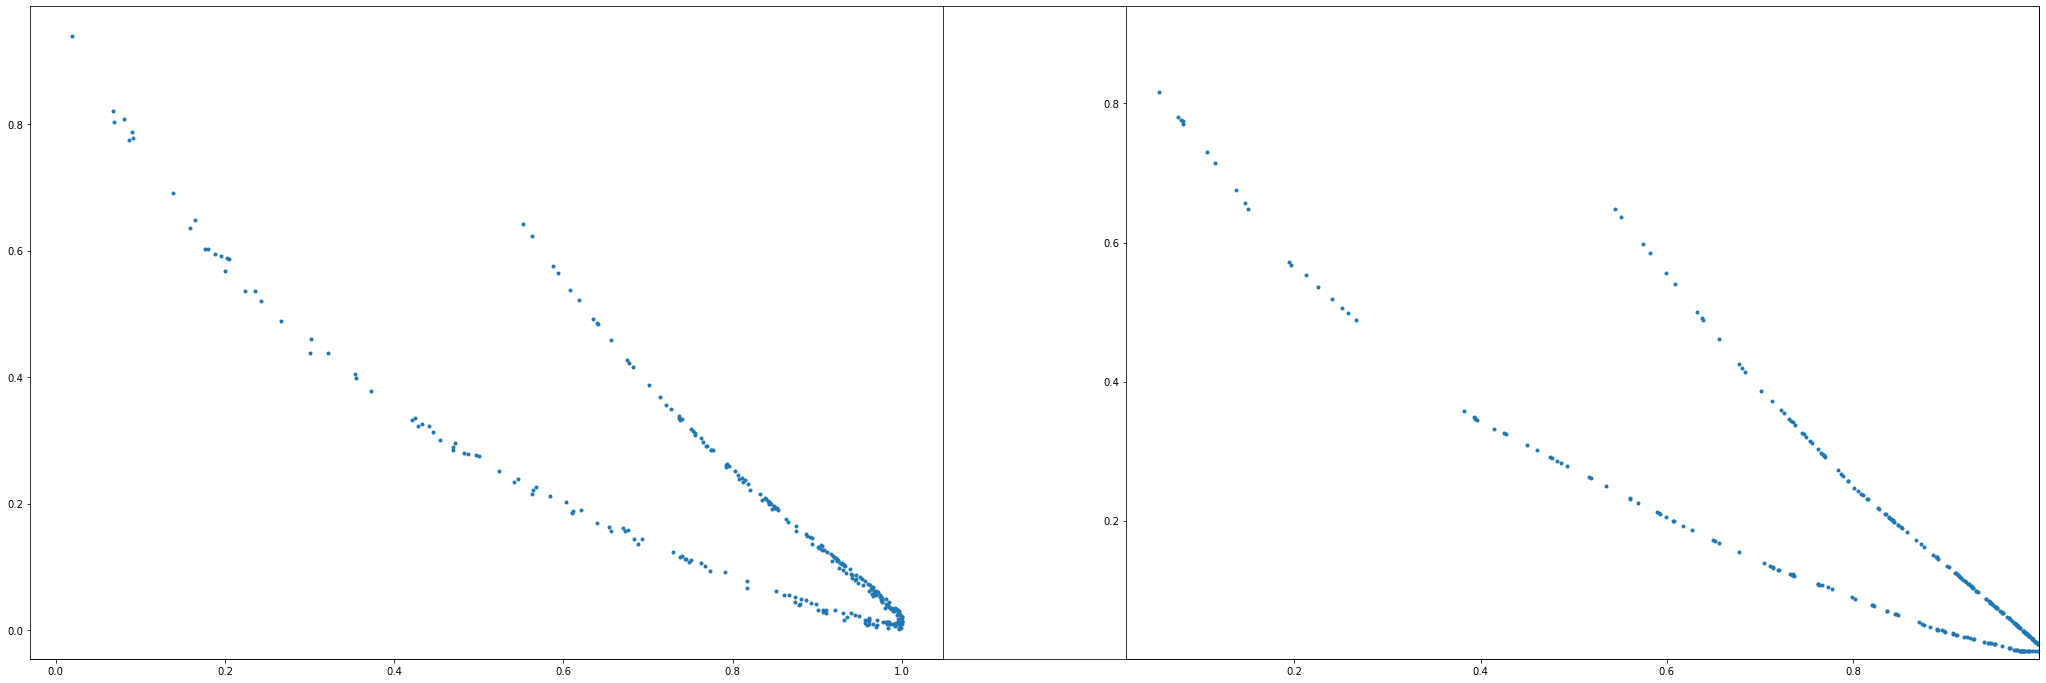

In [18]:
fig, axes = plt.subplots(figsize=(36, 12))
axes.get_xaxis().set_visible(False) # remove erroreas graph axis
axes.get_yaxis().set_visible(False)


xlim = [test_y[:,0].min(),test_y[:,0].max()]
ylim = [test_y[:,1].min(),test_y[:,1].max()]


ax = fig.add_subplot(121)
plt.plot(test_y[:,0],test_y[:,1], ".")
ax = fig.add_subplot(122)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.plot(final_preds[:,0],final_preds[:,1], ".")

plt.show()